In [1]:
import numpy as np
import math
import scipy
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
import dask
import scipy
import scipy.io as sio
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import ticker
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from mpl_toolkits.basemap import Basemap
from statistics import mode
from matplotlib import transforms
import itertools
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
bm = Basemap()
import netCDF4

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.ticker as mticker

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


In [2]:
fz = 15
lw = 3
siz = 100
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YTEXT = 0.3 # Text placement
LWC = 2.0

plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
matplotlib.rcParams['lines.linewidth'] = lw

In [3]:
#Good_July.nc
path_to_file = '/fast/gmooers/Preprocessed_Data/One_Month_July/full_physics_essentials_valid_month02_targets.nc'
real_ds = xr.open_dataset(path_to_file)

path_to_file = '/fast/gmooers/Models/Good_July.nc'
test_ds = xr.open_dataset(path_to_file)

print('files imported')

files imported


In [4]:
heat_SPCAM5 = real_ds.targets[:, 19].values

heat_DNN = test_ds.Prediction[:, 19].values

moisture_SPCAM5 = real_ds.targets[:, 49].values

moisture_DNN = test_ds.Prediction[:, 49].values

precip_SPCAM5 = real_ds.targets[:, -1].values

precip_DNN = test_ds.Prediction[:, -1].values

times = real_ds.time.values

lats = real_ds.lat.values

lons = real_ds.lon.values

In [5]:
x = 144
y = 96
z = 30
t = int(len(heat_SPCAM5)/(x*y))

Target_Heat = np.zeros(shape=(x, y, t))
NN_Heat = np.zeros(shape=(x, y, t))
Target_Moisture = np.zeros(shape=(x, y, t))
NN_Moisture = np.zeros(shape=(x, y, t))

Target_Precip = np.zeros(shape=(x, y, t))
NN_Precip = np.zeros(shape=(x, y, t))

count = 0
for i in range(t):
    for j in range(y):
        for k in range(x):
            A = heat_SPCAM5[count]
            B = heat_DNN[count]
            C = moisture_SPCAM5[count]
            D = moisture_DNN[count]
            E = precip_SPCAM5[count]
            F = precip_DNN[count]
            Target_Heat[k, j, i] = A
            NN_Heat[k, j, i] = B
            Target_Moisture[k, j, i] = C
            NN_Moisture[k, j, i] = D
            Target_Precip[k, j, i] = E
            NN_Precip[k, j, i] = F
            count = count + 1


In [6]:
others = netCDF4.Dataset("/Compressed_Data/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-72000.nc")
plev = np.array(others.variables['lev'])
ps = np.array(others.variables['PS'])
g = 9.81 #m/s^2
L = 2256000.0
#print(plev)
hyai = np.array(others.variables['hyai'])
hybi = np.array(others.variables['hybi'])
#print(hyai.shape)
#print(hyai)
cp = 1004.0
PS = 1e5
P0 = 1e5
P = P0*hyai+PS*hybi # Total pressure [Pa]
dp = P[1:]-P[:-1] # Differential pressure [Pa]
#convert from k/s to w/m^2


pressure_weighted_Target_Heat = Target_Heat*dp[19]*cp/g
pressure_weighted_NN_Heat = NN_Heat*dp[19]*cp/g

pressure_weighted_Target_Moisture = Target_Moisture*dp[19]*L/g
pressure_weighted_NN_Moisture = NN_Moisture*dp[19]*L/g

weighted_Target_Precip = Target_Precip*86400000.
weighted_NN_Precip = NN_Precip*86400000.

In [8]:
def Heat_Moisture_Small(heat_truth, heat_pred, moisture_truth, moisture_pred, timesteps, vmin, vmax):
    fig,ax = plt.subplots(2,2,figsize=(10,7.5),subplot_kw=dict(projection=ccrs.Robinson()))
    feat_list = []
    for i in range(timesteps):
        # (a) Convective Moistening
        im_a = ax[0,0].imshow(np.squeeze(moisture_truth[:,:,i]).T,cmap='bwr', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
        #im = ax[0,0].imshow(coor.TS[it,:,:].values,cmap='bwr',transform=ccrs.PlateCarree())
        ax[0,0].set_title('Cloud-Resolving Model')
        ax[0,0].set_global()
        ax[0,0].add_feature(cfeature.COASTLINE)
        if i == 0:
            cb = fig.colorbar(im_a, ax=ax[0,0], pad=0.01, extend='both', orientation='horizontal'); 
            cb.set_label('$\mathrm{600hPa\ Convective\ Moistening\ (W/m^{2})}$')

        # (b) Convective Heating
        im_b = ax[0,1].imshow(np.squeeze(heat_truth[:,:,i]).T, cmap='bwr', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
        ax[0,1].set_title('Cloud-Resolving Model')
        ax[0,1].add_feature(cfeature.COASTLINE)
        if i == 0:
            cb = fig.colorbar(im_b, ax=ax[0,1], pad=0.01, extend='both', orientation='horizontal'); 
            cb.set_label('$\mathrm{600hPa\ Convective\ Heating\ (W/m^{2})}$')

        # (a) Convective Moistening
        im_c = ax[1,0].imshow(np.squeeze(moisture_pred[:,:,i]).T,cmap='bwr', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
        ax[1,0].set_title('Neural Network')
        ax[1,0].add_feature(cfeature.COASTLINE)
        #cb = fig.colorbar(im, ax=ax[1,0], pad=0.01, extend='both', orientation='horizontal'); 
        #cb.set_label('$\mathrm{PRED\ 600hPa\ Convective\ Moistening\ (W/m^{2})}$')

        # (b) Convective Heating
        im_d = ax[1,1].imshow(np.squeeze(heat_pred[:,:,i]).T,cmap='bwr', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
        ax[1,1].set_title('Neural Network')
        ax[1,1].add_feature(cfeature.COASTLINE)
        
        feat_list.append([im_a, im_b, im_c, im_d])
    
    ani = animation.ArtistAnimation(fig, feat_list, interval = 100, blit = False, repeat = True)
    ani.save('Figures/Basic_Heat_Moisture.mp4')
    plt.show()
    
#Heat_Moisture_Small(pressure_weighted_Target_Heat, pressure_weighted_NN_Heat, pressure_weighted_Target_Moisture, pressure_weighted_NN_Moisture, 100, -150, 150)    

In [9]:
def Heat_Moisture(heat_truth, heat_pred, moisture_truth, moisture_pred, timesteps, vmin, vmax):
    fig,ax = plt.subplots(2,2,figsize=(10,7.5),subplot_kw=dict(projection=ccrs.Robinson()))
    feat_list = []
    for i in range(timesteps):
        if i %2 == 0:
            im_a = ax[0,0].imshow(np.squeeze(moisture_truth[:,:,i]).T,cmap='bwr', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[0,0].set_title('Cloud-Resolving Model')
            ax[0,0].set_global()
            ax[0,0].add_feature(cfeature.COASTLINE)
            if i == 0:
                cb = fig.colorbar(im_a, ax=ax[0,0], pad=0.01, extend='both', orientation='horizontal'); 
                cb.set_label('$\mathrm{600hPa\ Convective\ Moistening\ (W/m^{2})}$')

            im_b = ax[0,1].imshow(np.squeeze(heat_truth[:,:,i]).T, cmap='bwr', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[0,1].set_title('Cloud-Resolving Model')
            ax[0,1].add_feature(cfeature.COASTLINE)
            if i == 0:
                cb = fig.colorbar(im_b, ax=ax[0,1], pad=0.01, extend='both', orientation='horizontal'); 
                cb.set_label('$\mathrm{600hPa\ Convective\ Heating\ (W/m^{2})}$')

            im_c = ax[1,0].imshow(np.squeeze(moisture_pred[:,:,i]).T,cmap='bwr', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[1,0].set_title('Neural Network')
            ax[1,0].add_feature(cfeature.COASTLINE)

            im_d = ax[1,1].imshow(np.squeeze(heat_pred[:,:,i]).T,cmap='bwr', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[1,1].set_title('Neural Network')
            ax[1,1].add_feature(cfeature.COASTLINE)
        
            feat_list.append([im_a, im_b, im_c, im_d])
    
    ani = animation.ArtistAnimation(fig, feat_list, interval = 30, blit = False, repeat = True)
    ani.save('/fast/gmooers/Figures/14_days_heating_moistening.mp4')
    plt.show()
    
Heat_Moisture(pressure_weighted_Target_Heat, pressure_weighted_NN_Heat, pressure_weighted_Target_Moisture, pressure_weighted_NN_Moisture, 1342, -150, 150) 

In [10]:
def Daily_Precip(precip_truth, precip_pred, timesteps, vmin, vmax):
    fig,ax = plt.subplots(2,1,figsize=(5,7.5),subplot_kw=dict(projection=ccrs.Robinson()))
    feat_list = []
    for i in range(timesteps):
        im_a = ax[0].imshow(np.squeeze(precip_truth[:,:,i]).T,cmap='Greens', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
        ax[0].set_title('Cloud-Resolving Model')
        ax[0].set_global()
        ax[0].add_feature(cfeature.COASTLINE)
        if i == 0:
            cb = fig.colorbar(im_a, ax=ax[0], pad=0.01, extend='both', orientation='horizontal'); 
            cb.set_label('$\mathrm{Precipitation\ Rate\ (mm/day)}$')

        im_b = ax[1].imshow(np.squeeze(precip_pred[:,:,i]).T, cmap='Greens', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
        ax[1].set_title('Neural Network')
        ax[1].add_feature(cfeature.COASTLINE)
        
        feat_list.append([im_a, im_b])
    
    ani = animation.ArtistAnimation(fig, feat_list, interval = 100, blit = False, repeat = True)
    ani.save('/fast/gmooers/Figures/1_Day_Precip.mp4')
    plt.show()
    
#Daily_Precip(weighted_Target_Precip, weighted_NN_Precip, 100, 0, 50)    

In [11]:
def Two_Week_Precip(precip_truth, precip_pred, timesteps, vmin, vmax):
    fig,ax = plt.subplots(2,1,figsize=(5,7.5),subplot_kw=dict(projection=ccrs.Robinson()))
    feat_list = []
    for i in range(timesteps):
        if i%2==0:
            im_a = ax[0].imshow(np.squeeze(precip_truth[:,:,i]).T,cmap='Greens', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[0].set_title('Cloud-Resolving Model')
            ax[0].set_global()
            ax[0].add_feature(cfeature.COASTLINE)
            if i == 0:
                cb = fig.colorbar(im_a, ax=ax[0], pad=0.01, extend='both', orientation='horizontal'); 
                cb.set_label('$\mathrm{Precipitation\ Rate\ (mm/day)}$')

            im_b = ax[1].imshow(np.squeeze(precip_pred[:,:,i]).T, cmap='Greens', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[1].set_title('Neural Network')
            ax[1].add_feature(cfeature.COASTLINE)
        
            feat_list.append([im_a, im_b])
    
    ani = animation.ArtistAnimation(fig, feat_list, interval = 50, blit = False, repeat = True)
    ani.save('/fast/gmooers/Figures/14_Day_Precip.mp4')
    plt.show()
    
#Two_Week_Precip(weighted_Target_Precip, weighted_NN_Precip, 1342, 0, 50) 

In [13]:
log_weighted_Target_Precip = np.log10(weighted_Target_Precip)
log_weighted_NN_Precip = np.log10(weighted_NN_Precip)

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


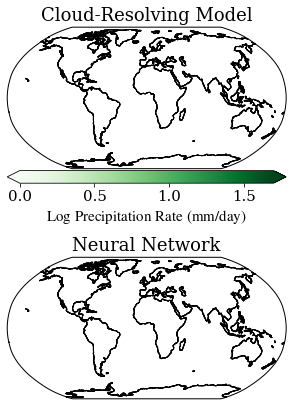

In [15]:
def Log_Precip(precip_truth, precip_pred, timesteps, vmin, vmax):
    fig,ax = plt.subplots(2,1,figsize=(5,7.5),subplot_kw=dict(projection=ccrs.Robinson()))
    feat_list = []
    for i in range(timesteps):
        if i%2==0:
            im_a = ax[0].imshow(np.squeeze(precip_truth[:,:,i]).T,cmap='Greens', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[0].set_title('Cloud-Resolving Model')
            ax[0].set_global()
            ax[0].add_feature(cfeature.COASTLINE)
            if i == 0:
                cb = fig.colorbar(im_a, ax=ax[0], pad=0.01, extend='both', orientation='horizontal'); 
                cb.set_label('$\mathrm{Log\ Precipitation\ Rate\ (mm/day)}$')

            im_b = ax[1].imshow(np.squeeze(precip_pred[:,:,i]).T, cmap='Greens', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[1].set_title('Neural Network')
            ax[1].add_feature(cfeature.COASTLINE)
        
            feat_list.append([im_a, im_b])
    
    ani = animation.ArtistAnimation(fig, feat_list, interval = 50, blit = False, repeat = True)
    ani.save('/fast/gmooers/Figures/14_Day_Log10_Precip.mp4')
    plt.show()
    
#Log_Precip(log_weighted_Target_Precip, log_weighted_NN_Precip, 1342, 0, 1.7) 